In [24]:
import os
import copy

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch import Tensor
from torch.utils.data import Dataset

from time import time 
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve



In [2]:
# TODOs:
# - try bce vs. mse loss
# - train on images with both images containing 1s and images of all 0s
# - train w/ images only containing 1s
# - choose validation model based on f1 score (get classification from the output probability)
# - try different features
# - try different patch sizes (64x64 and 128x128 are preprocessed already but you can run the preprocess script for other sizes)
# - Try different network hyperparameters
# - Try an autoencoder instead of a variational autoencoder

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [4]:
# target map fire value
FIRE_VAL = 1

DATA_DIR = '/home/capstone22/WildFIrePrediction/isaac_data/processed_data_64'

# using features recommended by isaac - pck
# FEATURES = [2,3,4,12,13,14,26,27,28,48,49,50,53] 
FEATURES = list(range(2,54))


## Load dataset

In [5]:
class IsaacDSImage(Dataset):
    """A Dataset class for image patches.
    """
    def __init__(self, split, features, data_dir, has_fire_only=False, min_fire=20):
        """Initialize dataset class.

        Args:
            split (str): Train/Valid/Test to be retrieved.
            features (list[int]): A list of channels indexes to used.
            data_dir (str): The path to the data directory.
            has_fire_only (bool, optional): Only load patches with fire. Defaults to False.
            min_fire (int, optional): Minimum number of fire pixel. Defaults to 20.
        """
        self.split = split
        self.features = features
        self.data_dir = data_dir
        self.split_map = {
            'train': np.arange(2003, 2013),
            'valid': np.arange(2013, 2015),
            'test': np.arange(2015, 2018)
        }
        self.has_fire_only = has_fire_only
        self.min_fire = min_fire
        self.data_x, self.data_y = self.get_data()
      

    def get_data(self):
        """Return the feature maps and target maps.
        """
        years = self.split_map[self.split]
        all_X, all_y = [], []
        
        # load patches from all years
        for year in years:
            X_path = os.path.join(self.data_dir, f'{year}.npy')
            y_path = os.path.join(self.data_dir, f'{year}_TD.npy')
            
            X = np.load(X_path, allow_pickle=True)
            y = np.load(y_path, allow_pickle=True)
            
            X = X[:,self.features,:,:]
            
            all_X.append(X)
            all_y.append(y)

        all_X = np.concatenate(all_X, axis=0)
        all_y = np.concatenate(all_y, axis=0)

        # only retain patches with fire
        if(self.has_fire_only):
            fire_indexes = []
            for i, patch in enumerate(all_y):
                if(np.any(patch == FIRE_VAL) and np.count_nonzero(patch == FIRE_VAL) > self.min_fire):
                    fire_indexes.append(i)
            
            all_X = all_X[fire_indexes]
            all_y = all_y[fire_indexes]

        return all_X, all_y
        
    def __len__(self):
        """Return the number of samples.
        """
        return len(self.data_x)
    
    def __getitem__(self, idx: int):
        """Return feature map and target map at index.
        """

        X = self.data_x[idx]
        y = self.data_y[idx]
        
        y = np.expand_dims(y, axis=0)
        
        X = X.astype('float32')
        y = y.astype('float32')
        
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        return X, y

In [6]:
trainset = IsaacDSImage('train', FEATURES, DATA_DIR, has_fire_only=True, min_fire=10)
valset = IsaacDSImage('valid', FEATURES, DATA_DIR)
testset = IsaacDSImage('test', FEATURES, DATA_DIR)

print(f'Training set samples: {trainset.__len__()}')
print(f'Validation set samples: {valset.__len__()}')
print(f'Testing set samples: {testset.__len__()}')


Training set samples: 233
Validation set samples: 570
Testing set samples: 855


In [7]:
# validation and testing loader need to have batch size of 80 for full map reconstruction
batch_size = 8
patches_per_image = valset.__len__() // 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size = patches_per_image, shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size = patches_per_image, shuffle=False, num_workers=0)

In [7]:
# # check data to make sure they look ok

# for i in range(trainset.__len__()):
#     X, y = trainset[i]
#     print(X.shape, y.shape)
#     print(trainset.__len__())

#     # plt.imshow(X[0, :,:])
#     # print(np.nanmin(X), np.nanmax(X))
#     plt.imshow(y[0])
#     plt.show()


## Define Variational Autoencoder Model

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input):
        # should be the same as non-flatten encoder output shape
        return input.view(input.size(0), 128, 2, 2) 

In [9]:
# VAE Model from https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
class VanillaVAE(nn.Module):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: list = None,
                 kernel_size: int = 5,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim # size of z (computed from encoder output(mean&std) and ε)
        self.kernel_size = kernel_size
        self.stride_size = self.kernel_size - 1

        modules = []
        # hidden_dims: # of filters for CNN
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512] # five hiddens_dims for images 64x64, six for 128x128
        
        self.last_hidden_dim = hidden_dims[-1]
        self.enc_img_width = int(64 / self.stride_size**(len(hidden_dims))) # encoder output img width
        self.enc_img_height = int(64 / self.stride_size**(len(hidden_dims)))
        self.enc_size = self.enc_img_width * self.enc_img_height

        # Build Encoder
        for i, h_dim in enumerate(hidden_dims):
            if(i==0):
                modules.append(
                    nn.Sequential(
                        # The mean and standard-deviation are calculated per-dimension separately for each object in a mini-batch.
                        nn.InstanceNorm2d(len(FEATURES), track_running_stats=False), # normalize across channel
                        nn.Conv2d(in_channels, out_channels=h_dim,
                                kernel_size=self.kernel_size, stride=self.stride_size, padding  = 1),
                        nn.BatchNorm2d(h_dim),
                        nn.LeakyReLU())
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Conv2d(in_channels, out_channels=h_dim,
                                kernel_size=self.kernel_size, stride=self.stride_size, padding  = 1),
                        nn.BatchNorm2d(h_dim),
                        nn.LeakyReLU())
                )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*self.enc_size, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*self.enc_size, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.enc_size)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=self.kernel_size,
                                       stride=self.stride_size,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=self.kernel_size,
                                               stride=self.stride_size,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            # nn.Conv2d(hidden_dims[-1], out_channels= 1,
                            #           kernel_size=self.kernel_size, padding= 1),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size=1),
                            nn.Sigmoid())

    def encode(self, input: Tensor) -> list:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W] (batch x # channel x height x width)
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        # print(f'Encoder output shape: {result.shape}')
        result = torch.flatten(result, start_dim=1)
        # print(f'Flatten encoder output shape: {result.shape}')


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        # print(f'Latent space expected shape: {self.fc_mu}')
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.last_hidden_dim, self.enc_img_height, self.enc_img_width)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1) (computing z).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> list:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), mu, log_var]

    #kld - match latent space distribution to gaussian
    #bce - reconstruction loss
    #loss - sum of the two
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        # distribution loss weight 
        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset, batch size / all training images

        # choose one
        # size_average = False -> sum of all pixels's loss 
        
#         recons_loss =F.mse_loss(recons, input, size_average=False)
        recons_loss =F.binary_cross_entropy(recons, input, size_average=False) 

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    # not used
    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

# Training and Validation

In [10]:
model = VanillaVAE(in_channels=len(FEATURES), 
                   latent_dim=1024,
                   hidden_dims = [64, 128],
                   kernel_size=5,
                  ).to(device)
summary(model, input_size=(batch_size, len(FEATURES), 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaVAE                               --                        --
├─Sequential: 1-1                        [8, 128, 4, 4]            --
│    └─Sequential: 2-1                   [8, 64, 16, 16]           --
│    │    └─InstanceNorm2d: 3-1          [8, 52, 64, 64]           --
│    │    └─Conv2d: 3-2                  [8, 64, 16, 16]           83,264
│    │    └─BatchNorm2d: 3-3             [8, 64, 16, 16]           128
│    │    └─LeakyReLU: 3-4               [8, 64, 16, 16]           --
│    └─Sequential: 2-2                   [8, 128, 4, 4]            --
│    │    └─Conv2d: 3-5                  [8, 128, 4, 4]            204,928
│    │    └─BatchNorm2d: 3-6             [8, 128, 4, 4]            256
│    │    └─LeakyReLU: 3-7               [8, 128, 4, 4]            --
├─Linear: 1-2                            [8, 1024]                 2,098,176
├─Linear: 1-3                            [8, 1024]                 

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [25]:
def stitch_imgs(output_imgs: np.ndarray) -> np.ndarray:
    """Stitch map patches together.

    Args:
        output_imgs (np.ndarray): Patches of map.

    Returns:
        np.ndarray: A numpy array of full map.
    """
    patch_size = 64
    HEIGHT = math.ceil(1209/patch_size)*patch_size
    WIDTH = math.ceil(941/patch_size)*patch_size
    arr = np.zeros((HEIGHT, WIDTH))

    _, _, dim_y, dim_x = output_imgs.shape

    for row in range(math.ceil(HEIGHT/dim_y)):
        for col in range(math.ceil(WIDTH/dim_x)):
            x = col*dim_x
            y = row*dim_y
            index = col + row*math.ceil(WIDTH/dim_x)
            arr[y:y+dim_y, x:x+dim_x] = output_imgs[index]

    return arr



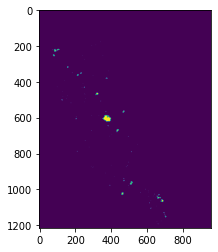

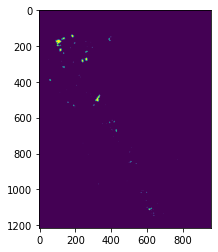

In [26]:
# test stich function
for idx, (input_imgs, output_imgs) in enumerate(valloader): 
    input_imgs = input_imgs.to(device)
    output_imgs = output_imgs.to(device)
    
    plt.imshow(stitch_imgs(output_imgs.cpu()), vmin=0, vmax=1)
    plt.show()

In [42]:
epochs = 200

/home/capstone22/WildFIrePrediction/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 -> loss: 3104.888, reconstruction loss: 3012.714, KL divergence loss: -2833.040
====== val reconstruction loss: 59463.086 ======
Epoch 1 -> loss: 3112.032, reconstruction loss: 3012.134, KL divergence loss: -4501.436
====== val reconstruction loss: 62976.461 ======
Epoch 2 -> loss: 3094.496, reconstruction loss: 2996.850, KL divergence loss: -3942.385
====== val reconstruction loss: 58714.961 ======
Epoch 3 -> loss: 3072.780, reconstruction loss: 2986.960, KL divergence loss: -2700.351
====== val reconstruction loss: 59714.090 ======
Epoch 4 -> loss: 3100.065, reconstruction loss: 3005.386, KL divergence loss: -2897.510
====== val reconstruction loss: 60132.203 ======
Epoch 5 -> loss: 3097.964, reconstruction loss: 3006.024, KL divergence loss: -2830.060
====== val reconstruction loss: 60075.395 ======
Epoch 6 -> loss: 3104.677, reconstruction loss: 3014.615, KL divergence loss: -2752.543
====== val reconstruction loss: 61152.281 ======
Epoch 7 -> loss: 3119.300, reconstruction

====== val reconstruction loss: 62213.750 ======
Epoch 60 -> loss: 3099.577, reconstruction loss: 3010.104, KL divergence loss: -2846.857
====== val reconstruction loss: 60685.039 ======
Epoch 61 -> loss: 3080.851, reconstruction loss: 2995.897, KL divergence loss: -2604.751
====== val reconstruction loss: 60609.344 ======
Epoch 62 -> loss: 3106.488, reconstruction loss: 3014.286, KL divergence loss: -2741.302
====== val reconstruction loss: 59724.508 ======
Epoch 63 -> loss: 3089.099, reconstruction loss: 3000.132, KL divergence loss: -2721.674
====== val reconstruction loss: 59969.461 ======
Epoch 64 -> loss: 3101.096, reconstruction loss: 3010.452, KL divergence loss: -2790.214
====== val reconstruction loss: 61063.273 ======
Epoch 65 -> loss: 3090.607, reconstruction loss: 3000.405, KL divergence loss: -2708.652
====== val reconstruction loss: 62368.051 ======
Epoch 66 -> loss: 3096.876, reconstruction loss: 3001.312, KL divergence loss: -2988.405
====== val reconstruction loss: 60

Epoch 119 -> loss: 3102.316, reconstruction loss: 3009.694, KL divergence loss: -2753.649
====== val reconstruction loss: 61585.906 ======
Epoch 120 -> loss: 3095.029, reconstruction loss: 3002.141, KL divergence loss: -3144.250
====== val reconstruction loss: 63181.691 ======
Epoch 121 -> loss: 3118.874, reconstruction loss: 3023.025, KL divergence loss: -2919.260
====== val reconstruction loss: 62457.070 ======
Epoch 122 -> loss: 3084.063, reconstruction loss: 2992.948, KL divergence loss: -2735.199
====== val reconstruction loss: 60129.438 ======
Epoch 123 -> loss: 3071.592, reconstruction loss: 2985.611, KL divergence loss: -2778.409
====== val reconstruction loss: 56430.504 ======
Epoch 124 -> loss: 3101.286, reconstruction loss: 3007.012, KL divergence loss: -2934.285
====== val reconstruction loss: 59855.492 ======
Epoch 125 -> loss: 3100.042, reconstruction loss: 3008.729, KL divergence loss: -2797.201
====== val reconstruction loss: 61191.871 ======
Epoch 126 -> loss: 3071.343

Epoch 178 -> loss: 3082.708, reconstruction loss: 2988.975, KL divergence loss: -2935.045
====== val reconstruction loss: 59713.121 ======
Epoch 179 -> loss: 3098.164, reconstruction loss: 3009.210, KL divergence loss: -2657.954
====== val reconstruction loss: 61808.953 ======
Epoch 180 -> loss: 3097.502, reconstruction loss: 3011.406, KL divergence loss: -2656.007
====== val reconstruction loss: 61423.336 ======
Epoch 181 -> loss: 3081.809, reconstruction loss: 2992.008, KL divergence loss: -2730.904
====== val reconstruction loss: 62218.664 ======
Epoch 182 -> loss: 3119.223, reconstruction loss: 3026.913, KL divergence loss: -2820.309
====== val reconstruction loss: 64087.039 ======
Epoch 183 -> loss: 3084.570, reconstruction loss: 2996.174, KL divergence loss: -2901.605
====== val reconstruction loss: 64423.676 ======
Epoch 184 -> loss: 3089.192, reconstruction loss: 3000.901, KL divergence loss: -2902.230
====== val reconstruction loss: 61272.750 ======
Epoch 185 -> loss: 3108.901

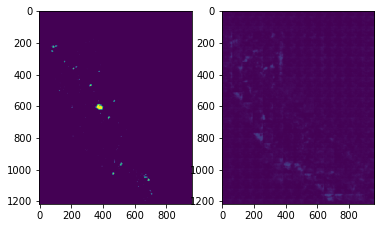

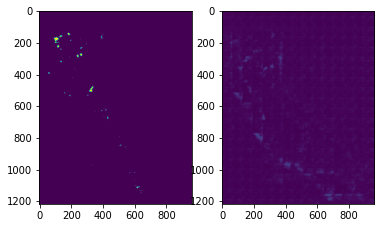

In [43]:
# Training
best_model = copy.deepcopy(model)
lowest_loss = np.inf
patience = np.inf
no_improvement = 0

for epoch in range(epochs):
    model.train()
    losses, bces, klds = 0, 0, 0
    for idx, (input_imgs, output_imgs) in enumerate(trainloader): 
        input_imgs = input_imgs.to(device)
        output_imgs = output_imgs.to(device)
        
        z, mu, log_var = model(input_imgs, labels = output_imgs)
        train_loss = model.loss_function(z, output_imgs, mu, log_var, 
                                          M_N = input_imgs.shape[0]/len(trainset)
                                        ) # sum of all pixels' loss in one batch
        optimizer.zero_grad()
        train_loss['loss'].backward()
        optimizer.step()

        losses += train_loss['loss']
        bces += train_loss['Reconstruction_Loss']
        klds += train_loss['KLD']

    # avg(sum of loss of all pixels per batch)  
    print(f'Epoch {epoch} -> loss: {losses/idx:.3f}, reconstruction loss: {bces/idx:.3f}, KL divergence loss: {klds/idx:.3f}')



    # Validation
    model.eval()
    val_losses, val_bces, val_klds = 0, 0, 0
    for idx, (input_imgs, output_imgs) in enumerate(valloader): 
        input_imgs = input_imgs.to(device)
        output_imgs = output_imgs.to(device)

        recon_images, mu, log_var = model(input_imgs, labels = output_imgs)
        val_loss = model.loss_function(recon_images, output_imgs, mu, log_var, 
                                        M_N = 1.0
                                        )

        val_losses += val_loss['loss']
        val_bces += val_loss['Reconstruction_Loss']
        val_klds += val_loss['KLD']

        # recon_images = recon_images.cpu().detach().numpy()
        # output_imgs = output_imgs.cpu().detach().numpy()


        # fig, axes = plt.subplots(1,2)
        # axes[0].imshow(stitch_imgs(output_imgs), vmin=0, vmax=1)
        # axes[1].imshow(stitch_imgs(recon_images), vmin=0, vmax=1)
        # plt.show()
    
    # loss per patch
    # print(f'Epoch {epoch} -> val loss: {val_losses/idx:.3f}, val reconstruction loss: {val_bces/idx:.3f}, val KL divergence loss: {val_klds/idx:.3f}')
    print(f'====== val reconstruction loss: {val_bces/idx:.3f} ======')

    if(val_bces/idx < lowest_loss):
        lowest_loss = val_bces/idx
        best_model = copy.deepcopy(model)
        no_improvement = 0
    else:
        no_improvement += 1
        if(no_improvement == patience):
            break

# Validation
model = best_model
model.eval()
val_losses, val_bces, val_klds = 0, 0, 0
for idx, (input_imgs, output_imgs) in enumerate(valloader): 
    input_imgs = input_imgs.to(device)
    output_imgs = output_imgs.to(device)

    recon_images = model.generate(input_imgs)

    recon_images = recon_images.cpu().detach().numpy()
    output_imgs = output_imgs.cpu().detach().numpy()


    fig, axes = plt.subplots(1,2)
    axes[0].imshow(stitch_imgs(output_imgs), vmin=0, vmax=1)
    axes[1].imshow(stitch_imgs(recon_images), vmin=0, vmax=1)
    plt.show()

# torch.save(vae.state_dict(), 'vae.torch')

AUC score: 0.48507487373487507


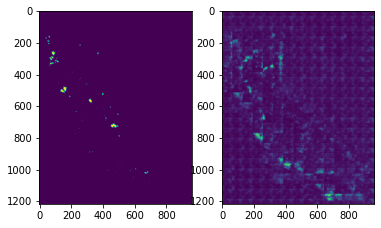

AUC score: 0.7500401317338332


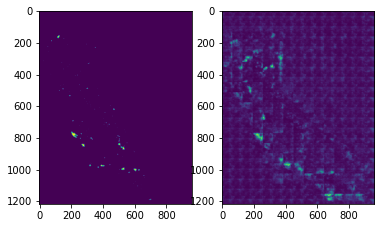

AUC score: 0.5817933168421501


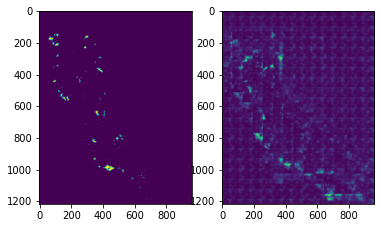

In [49]:
# Testing
model.eval()
val_losses, val_bces, val_klds = 0, 0, 0
for idx, (input_imgs, output_imgs) in enumerate(testloader): 
    input_imgs = input_imgs.to(device)
    output_imgs = output_imgs.to(device)

    recon_images = model.generate(input_imgs)

    recon_images = recon_images.cpu().detach().numpy()
    output_imgs = output_imgs.cpu().detach().numpy()


    fig, axes = plt.subplots(1,2)
    
    ref_img = stitch_imgs(output_imgs)
    recon_img = stitch_imgs(recon_images)
    
    axes[0].imshow(ref_img)
    axes[1].imshow(recon_img)
    
    print(f'AUC score: {roc_auc_score(ref_img.flatten(), recon_img.flatten())}')
    
    
    plt.show()
        

In [48]:
# torch.save(model, './vae.pt')
model = torch.load('./trained/vae.pt')

In [17]:
# mapping = {
#     0: 'pixel_id', 
#     1: 'pixel_id.1', 
#     2: 'Road_Dist', 
#     3: 'Elec_Dist', 
#     4: 'Cultivated_Prop', 
#     5: 'Elev', 
#     6: 'time_Normal', 
#     7: 'aet__count_above_mean_Normal', 
#     8: 'aet__count_below_mean_Normal', 
#     9: 'aet__first_location_of_maximum_Normal', 
#     10: 'aet__last_location_of_maximum_Normal', 
#     11: 'aet__longest_strike_above_mean_Normal', 
#     12: 'aet__longest_strike_below_mean_Normal', 
#     13: 'aet__maximum_Normal', 
#     14: 'aet__mean_Normal', 
#     15: 'aet__minimum_Normal', 
#     16: 'aet__quantile__q_0.1_Normal', 
#     17: 'aet__quantile__q_0.5_Normal', 
#     18: 'aet__quantile__q_0.9_Normal', 
#     19: 'aet__skewness_Normal', 
#     20: 'aet__standard_deviation_Normal', 
#     21: 'cwd__count_above_mean_Normal', 
#     22: 'cwd__count_below_mean_Normal', 
#     23: 'cwd__first_location_of_maximum_Normal', 
#     24: 'cwd__last_location_of_maximum_Normal', 
#     25: 'cwd__longest_strike_above_mean_Normal', 
#     26: 'cwd__longest_strike_below_mean_Normal', 
#     27: 'cwd__maximum_Normal', 
#     28: 'cwd__mean_Normal', 
#     29: 'cwd__minimum_Normal', 
#     30: 'cwd__quantile__q_0.1_Normal', 
#     31: 'cwd__quantile__q_0.5_Normal', 
#     32: 'cwd__quantile__q_0.9_Normal', 
#     33: 'cwd__skewness_Normal', 
#     34: 'cwd__standard_deviation_Normal', 
#     35: 'pck__count_above_mean_Normal', 
#     36: 'pck__count_below_mean_Normal', 
#     37: 'pck__first_location_of_maximum_Normal', 
#     38: 'pck__last_location_of_maximum_Normal', 
#     39: 'pck__longest_strike_above_mean_Normal', 
#     40: 'pck__longest_strike_below_mean_Normal', 
#     41: 'pck__maximum_Normal', 
#     42: 'pck__mean_Normal', 
#     43: 'pck__minimum_Normal', 
#     44: 'pck__quantile__q_0.1_Normal', 
#     45: 'pck__quantile__q_0.5_Normal', 
#     46: 'pck__quantile__q_0.9_Normal', 
#     47: 'pck__skewness_Normal', 
#     48: 'pck__standard_deviation_Normal', 
#     49: 'time', 
#     50: 'aet__mean_ThreeYear_Dev', 
#     51: 'cwd__mean_ThreeYear_Dev', 
#     52: 'Mean_Housing_Dens_25km', 
#     53: 'FFWI', 
#     54: 'FFWI_UCLA', 
#     55: 'time_since_fire'}